In [10]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm

from qec_generator import CircuitParams
from simulate_qec_rounds_stim import experiment_run
from stim_lib.scheduled_circuit import generate_scheduled
from scipy.optimize import curve_fit
import stim
from collections import namedtuple

In [11]:
import logging

In [13]:
Errors = namedtuple('Errors', ['p1', 'p2', 'pm', 'pr'])

encoding = stim.Circuit('''
    R 1 2 3 4 5 6 7 8 9 10
    H 1 5 7
    CNOT 1 2 5 6
    CNOT 7 4
    CNOT 7 6 5 3
    CNOT 1 4
    CNOT 5 2
    CNOT 4 3
    CNOT 2 8
    CNOT 4 8
    CNOT 6 8
    MR 8
''')

measure = stim.Circuit('''
    M 1 2 3 4 5 6 7
''')

H = np.array([
        [1, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 1, 1],
      ])

array([[1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 1, 1]])

In [98]:
def weight_1_qubit_index(syndrome):
    match = np.flatnonzero(np.all(H.T == syndrome, axis=1))
    if len(match) == 0:
        return 0
    else:
        return match[0] + 1
    assert len(match)


def prep_zero():
    sim = stim.TableauSimulator()
    sim.do(encoding)
    return sim


def meas_flagging_syndromes_xzz(state, errors):
    p1, p2, pm, pr = errors
    first_flag_circ = stim.Circuit(f'''
    
    
        # inject data error
        #PAULI_CHANNEL_1(0, 0, {p2}) 5
        #X 5
        
        
        H 8
        DEPOLARIZE1({p1}) 8 
        CNOT 8 4
        DEPOLARIZE2({p2}) 8 4
        CNOT 3 10
        DEPOLARIZE2({p2}) 3 10
        CNOT 6 9
        DEPOLARIZE2({p2}) 6 9
        CNOT 8 9  # 1st flag
        DEPOLARIZE2({p2}) 8 9
        CNOT 8 1
        DEPOLARIZE2({p2}) 8 1
        CNOT 4 10
        DEPOLARIZE2({p2}) 4 10
        CNOT 5 9
        DEPOLARIZE2({p2}) 5 9

        # inject flag error 1
        # X 8

        CNOT 8 2
        DEPOLARIZE2({p2}) 8 2
        CNOT 7 10
        DEPOLARIZE2({p2}) 7 10
        CNOT 3 9
        DEPOLARIZE2({p2}) 3 9
        CNOT 8 10  # second flag
        DEPOLARIZE2({p2}) 8 10
        CNOT 8 3
        DEPOLARIZE2({p2}) 8 3
        CNOT 6 10
        DEPOLARIZE2({p2}) 6 10

        CNOT 2 9
        DEPOLARIZE2({p2}) 2 9
        H 8
        DEPOLARIZE1({p1}) 8
        PAULI_CHANNEL_1(0, 0, {pm}) 8 9 10
        MR 8 9 10
        PAULI_CHANNEL_1(0, 0, {pr}) 8 9 10
    ''')
    
    state.do(first_flag_circ)
    yyy = tuple(np.array(state.current_measurement_record())[-3:].astype(np.uint8))
    return yyy


def meas_flagging_syndromes_zxx(state, errors):
    p1, p2, pm, pr = errors
    second_flag_circ = stim.Circuit(f'''
        H 9 10
        DEPOLARIZE1({p1}) 9 10
        CNOT 4 8
        DEPOLARIZE2({p2}) 4 8
        CNOT 10 3
        DEPOLARIZE2({p2}) 10 3
        CNOT 9 6
        DEPOLARIZE2({p2}) 9 6
        CNOT 9 8  # 1st flag
        DEPOLARIZE2({p2}) 9 8
        CNOT 1 8
        DEPOLARIZE2({p2}) 1 8
        CNOT 10 4
        DEPOLARIZE2({p2}) 10 4
        CNOT 9 5
        DEPOLARIZE2({p2}) 9 5

        # inject flag error 1
        # Z 8

        CNOT 2 8
        DEPOLARIZE2({p2}) 2 8
        CNOT 10 7
        DEPOLARIZE2({p2}) 10 7
        CNOT 9 3
        DEPOLARIZE2({p2}) 9 3
        CNOT 10 8  # 2nd flag
        DEPOLARIZE2({p2}) 10 8
        CNOT 3 8
        DEPOLARIZE2({p2}) 3 8
        CNOT 10 6
        DEPOLARIZE2({p2}) 10 6
        CNOT 9 2
        DEPOLARIZE2({p2}) 9 2
        H 9 10
        DEPOLARIZE1({p2}) 9 10
        
        #PAULI_CHANNEL_1(0, 0, {pm}) 8 9 10
        MR 8 9 10
        #PAULI_CHANNEL_1(0, 0, {pr}) 8 9 10
    ''')
    state.do(second_flag_circ)
    return tuple(np.array(state.current_measurement_record())[-3:].astype(np.uint8))


def meas_six_syndromes(state, errors):
    p1, p2, pm, pr = errors
    unflagged = stim.Circuit(f'''
        H 8 9 10
        DEPOLARIZE1({p1}) 8 9 10
        
        CNOT 8 1 8 2 8 3 8 4
        DEPOLARIZE2({p2}) 8 1 8 2 8 3 8 4
        
        CNOT 9 2 9 3 9 5 9 6
        DEPOLARIZE2({p2}) 9 2 9 3 9 5 9 6
        
        CNOT 10 3 10 4 10 6 10 7
        DEPOLARIZE2({p2}) 10 3 10 4 10 6 10 7
        
        H 8 9 10
        DEPOLARIZE1({p2}) 8 9 10
        
        #PAULI_CHANNEL_1(0, 0, {pm}) 8 9 10
        MR 8 9 10
        #PAULI_CHANNEL_1(0, 0, {pr}) 8 9 10
        
        CNOT 1 8 2 8 3 8 4 8
        DEPOLARIZE2({p2}) 1 8 2 8 3 8 4 8
        
        CNOT 2 9 3 9 5 9 6 9
        DEPOLARIZE2({p2}) 2 9 3 9 5 9 6 9
        
        CNOT 3 10 4 10 6 10 7 10
        DEPOLARIZE2({p2}) 3 10 4 10 6 10 7 10
        
        #PAULI_CHANNEL_1(0, 0, {pm}) 8 9 10
        MR 8 9 10
        #PAULI_CHANNEL_1(0, 0, {pr}) 8 9 10
    ''')
    state.do(unflagged)
    rec = np.array(state.current_measurement_record())[-6:].astype(np.uint8)
    return rec[-6:-3], rec[-3:]


def meas_z_data(state):
    state.do(measure)
    return np.array(state.current_measurement_record())[-7:].astype(np.uint8)

In [99]:
# note: we only test here the |0> state

def qec_cycles_exp (num_cycles, shots, errors):
    runs = 0
    success = 0
    for i in range (shots):
        logging.debug(f'shot={i}\n---------')
        state = prep_zero()
        last_syndromes_x = np.zeros(3, dtype=np.uint8)
        last_syndromes_z = np.zeros(3, dtype=np.uint8)
        pf = np.zeros(2, dtype=np.uint8)

        for j in range (num_cycles):
            logging.debug(f'cycle={j}\n---------')
            state, last_syndromes_x, last_syndromes_z, pf = qec_cycle(state, last_syndromes_x, last_syndromes_z, pf, errors)

        meas_output = logical_meas(state, last_syndromes_z, pf)
        logging.debug(f'meas output={meas_output}')
        
        expected_outcome = expected_result(meas_output)
        success += expected_outcome
        runs += 1

    return runs, success


def qec_cycle(state, last_syndrome_x, last_syndrome_z, pf, errors):
    flag_diff_x = np.zeros(3, dtype=np.uint8)
    flag_diff_z = np.zeros(3, dtype=np.uint8)
    fx0, fz1, fz2 = meas_flagging_syndromes_xzz(state, errors)
    
    flag_diff_x[0] = fx0 ^ last_syndrome_x[0]
    flag_diff_z[1] = fz1 ^ last_syndrome_z[1]
    flag_diff_z[2] = fz2 ^ last_syndrome_z[2]
    
    logging.debug('first flag round')
    logging.debug(f'flag diff x={flag_diff_x} flag diff z={flag_diff_z}')
    
    if np.all(flag_diff_x == [0] * 3) and np.all(flag_diff_z == [0] * 3):
        fz0, fx1, fx2 = meas_flagging_syndromes_zxx(state, errors)
    
        flag_diff_z[0] = (fz0 + last_syndrome_z[0]) % 2
        flag_diff_x[1] = (fx1 + last_syndrome_x[1]) % 2
        flag_diff_x[2] = (fx2 + last_syndrome_x[2]) % 2
        
        logging.debug('second flag round')
        logging.debug(f'flag diff x={flag_diff_x} flag diff z={flag_diff_z}')
        
    if np.any(flag_diff_x != [0] * 3) or np.any(flag_diff_z != [0] * 3):
        syndromes_x, syndromes_z = meas_six_syndromes(state, errors)
        syndrome_diff_x = (syndromes_x + last_syndrome_x) % 2
        syndrome_diff_z = (syndromes_z + last_syndrome_z) % 2
        
        logging.debug('unflagged correction')
        logging.debug(f'syndrome diff x={syndrome_diff_x} syndrome diff z={syndrome_diff_z}')

        logging.debug(f'unflagged w1 qubit x= {weight_1_qubit_index(syndrome_diff_x)} unflagged w1 qubit z={weight_1_qubit_index(syndrome_diff_z)}')
        logging.debug(f'flagged w1 qubit x= {weight_1_qubit_index(flag_diff_x)} flagged w1 qubit z={weight_1_qubit_index(flag_diff_z)}')

        unflagged_decode_x = decoder_2d(syndrome_diff_x)
        flag_correction_x = decoder_flag_update(syndrome_diff_x, flag_diff_x)
        unflagged_decode_z = decoder_2d(syndrome_diff_z)
        flag_correction_z = decoder_flag_update(syndrome_diff_z, flag_diff_z)
              
        logging.debug(f'unflagged decode x={unflagged_decode_x} flag correction x={flag_correction_x}' )
        logging.debug(f'unflagged decode z={unflagged_decode_z} flag correction z={flag_correction_z}' )
        pf[0] = (pf[0] + unflagged_decode_z + flag_correction_z) % 2
        pf[1] = (pf[1] + unflagged_decode_x + flag_correction_x) % 2
        
        logging.debug(f'pauli frame={pf}')
        
        last_syndrome_x = syndromes_x
        last_syndrome_z = syndromes_z
        
    return state, last_syndrome_x, last_syndrome_z, pf


def logical_meas(state, last_syndrome_z, pf):
    m = meas_z_data(state)
    meas_output = np.sum(m[4:7]) % 2
    
    syndromes = (H @ m) % 2
    
    syndrome_diff = (syndromes + last_syndrome_z) % 2
    final_correction = decoder_2d(syndrome_diff)
    return (meas_output + final_correction + pf[0]) % 2


def expected_result(meas_output):
    return (1 + meas_output) % 2



def decoder_2d(syndrome_diff):
    bad_syndromes = [[0, 1, 0], [0, 1, 1], [0, 0, 1]]
    if syndrome_diff.tolist() in bad_syndromes:
        return 1
    return 0
    
    
def decoder_flag_update(syndrome_diff, flag_diff):
    if np.all(flag_diff == [1, 0, 0]) and np.all(syndrome_diff == [0, 1, 0]):
        return 1
    if np.all(flag_diff == [1, 0, 0]) and np.all(syndrome_diff == [0, 0, 1]):
        return 1    
    if np.all(flag_diff == [0, 1, 1]) and np.all(syndrome_diff == [0, 0, 1]):
        return 1
    
    return 0
    

In [105]:
logging.basicConfig(level=logging.INFO, force=True)

p_vec = np.logspace(-3, -1, 10)
e_vec = []
for p in p_vec:
    errors = Errors(p1=p, p2=p, pm=p, pr=p)
    runs, success = qec_cycles_exp(num_cycles=1, shots=10000, errors=errors)
    e_vec.append(1 - success / runs)
    
e_vec = np.array(e_vec)
print(e_vec)

[1.000e-04 5.000e-04 1.600e-03 3.400e-03 1.000e-02 2.560e-02 6.700e-02
 1.447e-01 2.584e-01 3.814e-01]


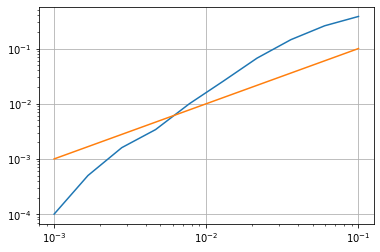

In [106]:
plt.loglog(p_vec, e_vec)
plt.loglog(p_vec, p_vec)
plt.grid('all')